Task:\
-Smooth map using Gaussian filtre.\
-Pick out 20000 hot and 20000 cold points on map\
-In local peak of angular size 5x5 degrees, calculate T, Qr and Ur and add

In [1]:
import numpy as np
import matplotlib
from matplotlib import pyplot as plt
import camb
import healpy as hp
from camb import model, initialpower
from mpl_toolkits.axes_grid1 import make_axes_locatable
from matplotlib.colors import LogNorm
from matplotlib.ticker import MultipleLocator

planck2018pars = camb.read_ini("planck_2018.ini")
planck2018 = camb.get_results(planck2018pars)

In [2]:
# Define Qr and Ur parameters
def Qr(Q, U, phi):
    Qr = -Q * np.cos(2 * phi) - U * np.sin(2 * phi)
    return Qr


def Ur(Q, U, phi):
    Ur = Q * np.sin(2 * phi) - U * np.cos(2 * phi)
    return Ur


# function which takes hp.pix2ang(lonlat=True) outputs of longitude and latitude in degrees and converts them into an angle from the east from the central point
def east_phi(lon_c, lat_c, lon_p, lat_p):
    dlon = np.radians(lon_p - lon_c)
    dlat = np.radians(lat_p - lat_c)
    # angle from east with east pointing left
    return np.arctan2(dlat, -dlon)


# angle is in radians

In [3]:
# unnormalised Cl
powers = planck2018.get_cmb_power_spectra(planck2018pars, CMB_unit="muK", raw_cl=True)

# total power spectrum
aCl_Total = powers["total"]

# l starts from 0 (monopole)
lmax = aCl_Total.shape[0] - 1
# l steps
aL = np.arange(lmax + 1)
# resolution of map
nside = 512

In [4]:
almT, almE, almB = hp.synalm(
    [
        np.array(aCl_Total[:, 0]),
        np.array(aCl_Total[:, 1]),
        np.array(aCl_Total[:, 2]),
        np.array(aCl_Total[:, 3]),
    ],
    new=True,
)
sharp_map = hp.alm2map([almT, almE, almB], nside=nside)
smooth = hp.smoothing(sharp_map, np.radians(0.5))
# print(np.min(smooth[0]), np.max(smooth[0]))
# print(np.min(smooth[1]), np.max(smooth[1]))
# print(np.min(smooth[2]), np.max(smooth[2]))

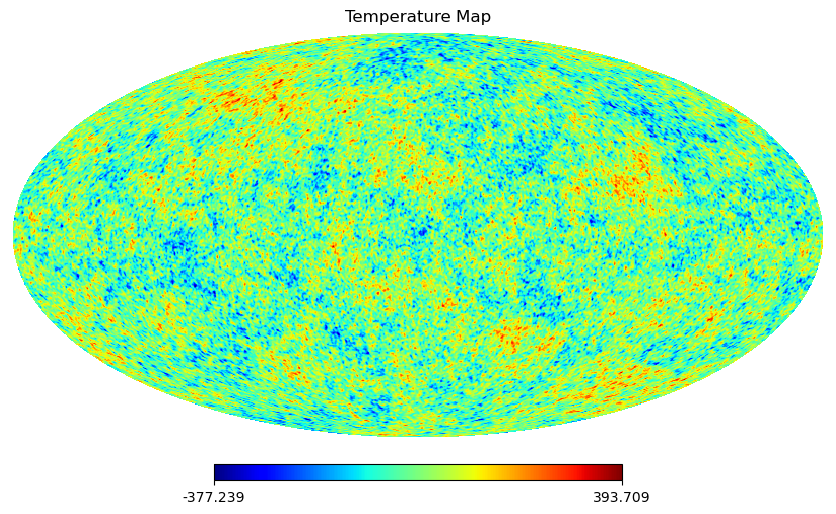

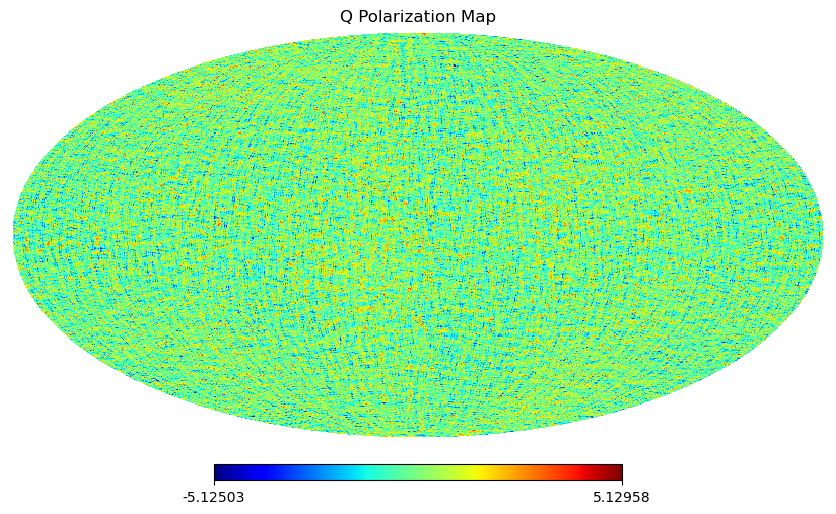

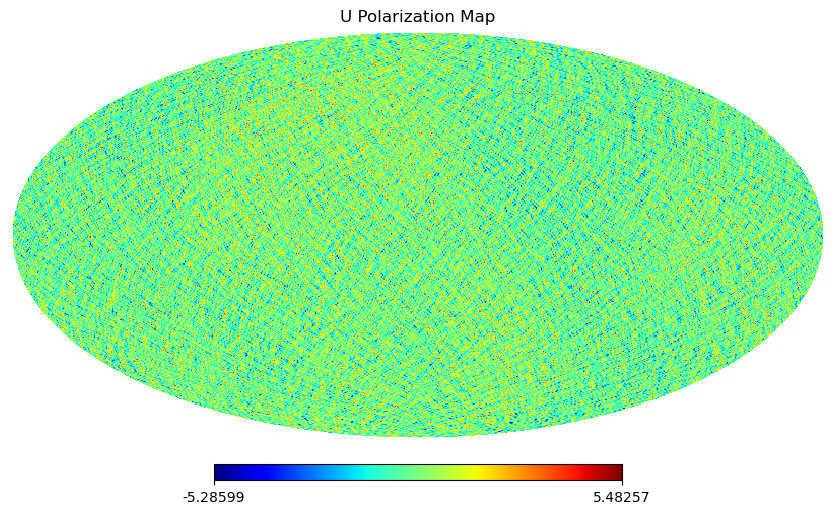

In [5]:
hp.mollview(
    smooth[0],
    max=np.max(smooth[0]),
    min=np.min(smooth[0]),
    cmap="jet",
    title="Temperature Map",
)
hp.mollview(
    smooth[1],
    max=np.max(smooth[1]),
    min=np.min(smooth[1]),
    cmap="jet",
    title="Q Polarization Map",
)
hp.mollview(
    smooth[2],
    max=np.max(smooth[2]),
    min=np.min(smooth[2]),
    cmap="jet",
    title="U Polarization Map",
)

In [30]:
# Finding 20000 hot and cold spots from smooth maps
no_spots = 1000
# indices of the spots with highest values
top_index = np.argsort(smooth[0])[-no_spots:]
# indices of the spots with the lowest values
bottom_index = np.argsort(smooth[0])[:no_spots]

In [31]:
# generating arrays which will contain averaged data
max_stacked = np.zeros((3, 200, 200))
min_stacked = np.zeros((3, 200, 200))

In [32]:
for i in range(len(top_index)):
    # find angluar position of pixels in longitude and latitude degrees
    max_long, max_lat = hp.pix2ang(nside, top_index[i], lonlat=True)
    min_long, min_lat = hp.pix2ang(nside, bottom_index[i], lonlat=True)
    # find position vector of given angular position
    max_pos = hp.ang2vec(max_long, max_lat, lonlat=True)
    min_pos = hp.ang2vec(min_long, min_lat, lonlat=True)
    # find neighbours within a 5x5 degrees about max point
    max_neighbours = hp.query_disc(nside, max_pos, np.radians(np.sqrt(2 * 2.5**2)))
    min_neighbours = hp.query_disc(nside, min_pos, np.radians(np.sqrt(2 * 2.5**2)))
    # find longitude and latitude for all the neighbour points
    max_neighbours_lon, max_neighbours_lat = hp.pix2ang(
        nside, max_neighbours, lonlat=True
    )
    min_neighbours_lon, min_neighbours_lat = hp.pix2ang(
        nside, min_neighbours, lonlat=True
    )

    # create array of masked pixel values(empty map) 0 = T, 1 = Qr, 2 = Ur
    sub_max = np.full((3, hp.nside2npix(nside)), 0)
    sub_min = np.full((3, hp.nside2npix(nside)), 0)
    # where the pixel indices match the indices of the neighbours, replace the empty values with the values of the neighbours at their location
    # T
    sub_max[0, max_neighbours] = smooth[0, max_neighbours]
    sub_min[0, min_neighbours] = smooth[0, min_neighbours]
    # Qr
    phi_max = east_phi(max_long, max_lat, max_neighbours_lon, max_neighbours_lat)
    phi_min = east_phi(min_long, min_lat, min_neighbours_lon, min_neighbours_lat)
    sub_max[1, max_neighbours] = Qr(
        smooth[1, max_neighbours],
        smooth[2, max_neighbours],
        phi_max,
    )
    sub_min[1, min_neighbours] = Qr(
        smooth[1, min_neighbours],
        smooth[2, min_neighbours],
        phi_min,
    )
    # Ur
    sub_max[2, max_neighbours] = Ur(
        smooth[1, max_neighbours],
        smooth[2, max_neighbours],
        phi_max,
    )
    sub_min[2, min_neighbours] = Ur(
        smooth[1, min_neighbours],
        smooth[2, min_neighbours],
        phi_min,
    )
    # default xsize = 200
    # creating a map centred at rot(coordinates of the central peak) and adding to the stacked map

    for i in range(3):
        max_stacked[i, :, :] += hp.gnomview(
            sub_max[i, :],
            rot=(max_long, max_lat),
            reso=5 * 60 / 200,
            return_projected_map=True,
            no_plot=True,
        )
        min_stacked[i, :, :] += hp.gnomview(
            sub_min[i, :],
            rot=(min_long, min_lat),
            reso=5 * 60 / 200,
            return_projected_map=True,
            no_plot=True,
        )

In [33]:
# Find the average of the sum of temperatures
max_stacked /= no_spots
min_stacked /= no_spots

/var/folders/xr/8_fm0nn90x74x5n0j96glblw0000gn/T/ipykernel_48744/3054611104.py:33: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


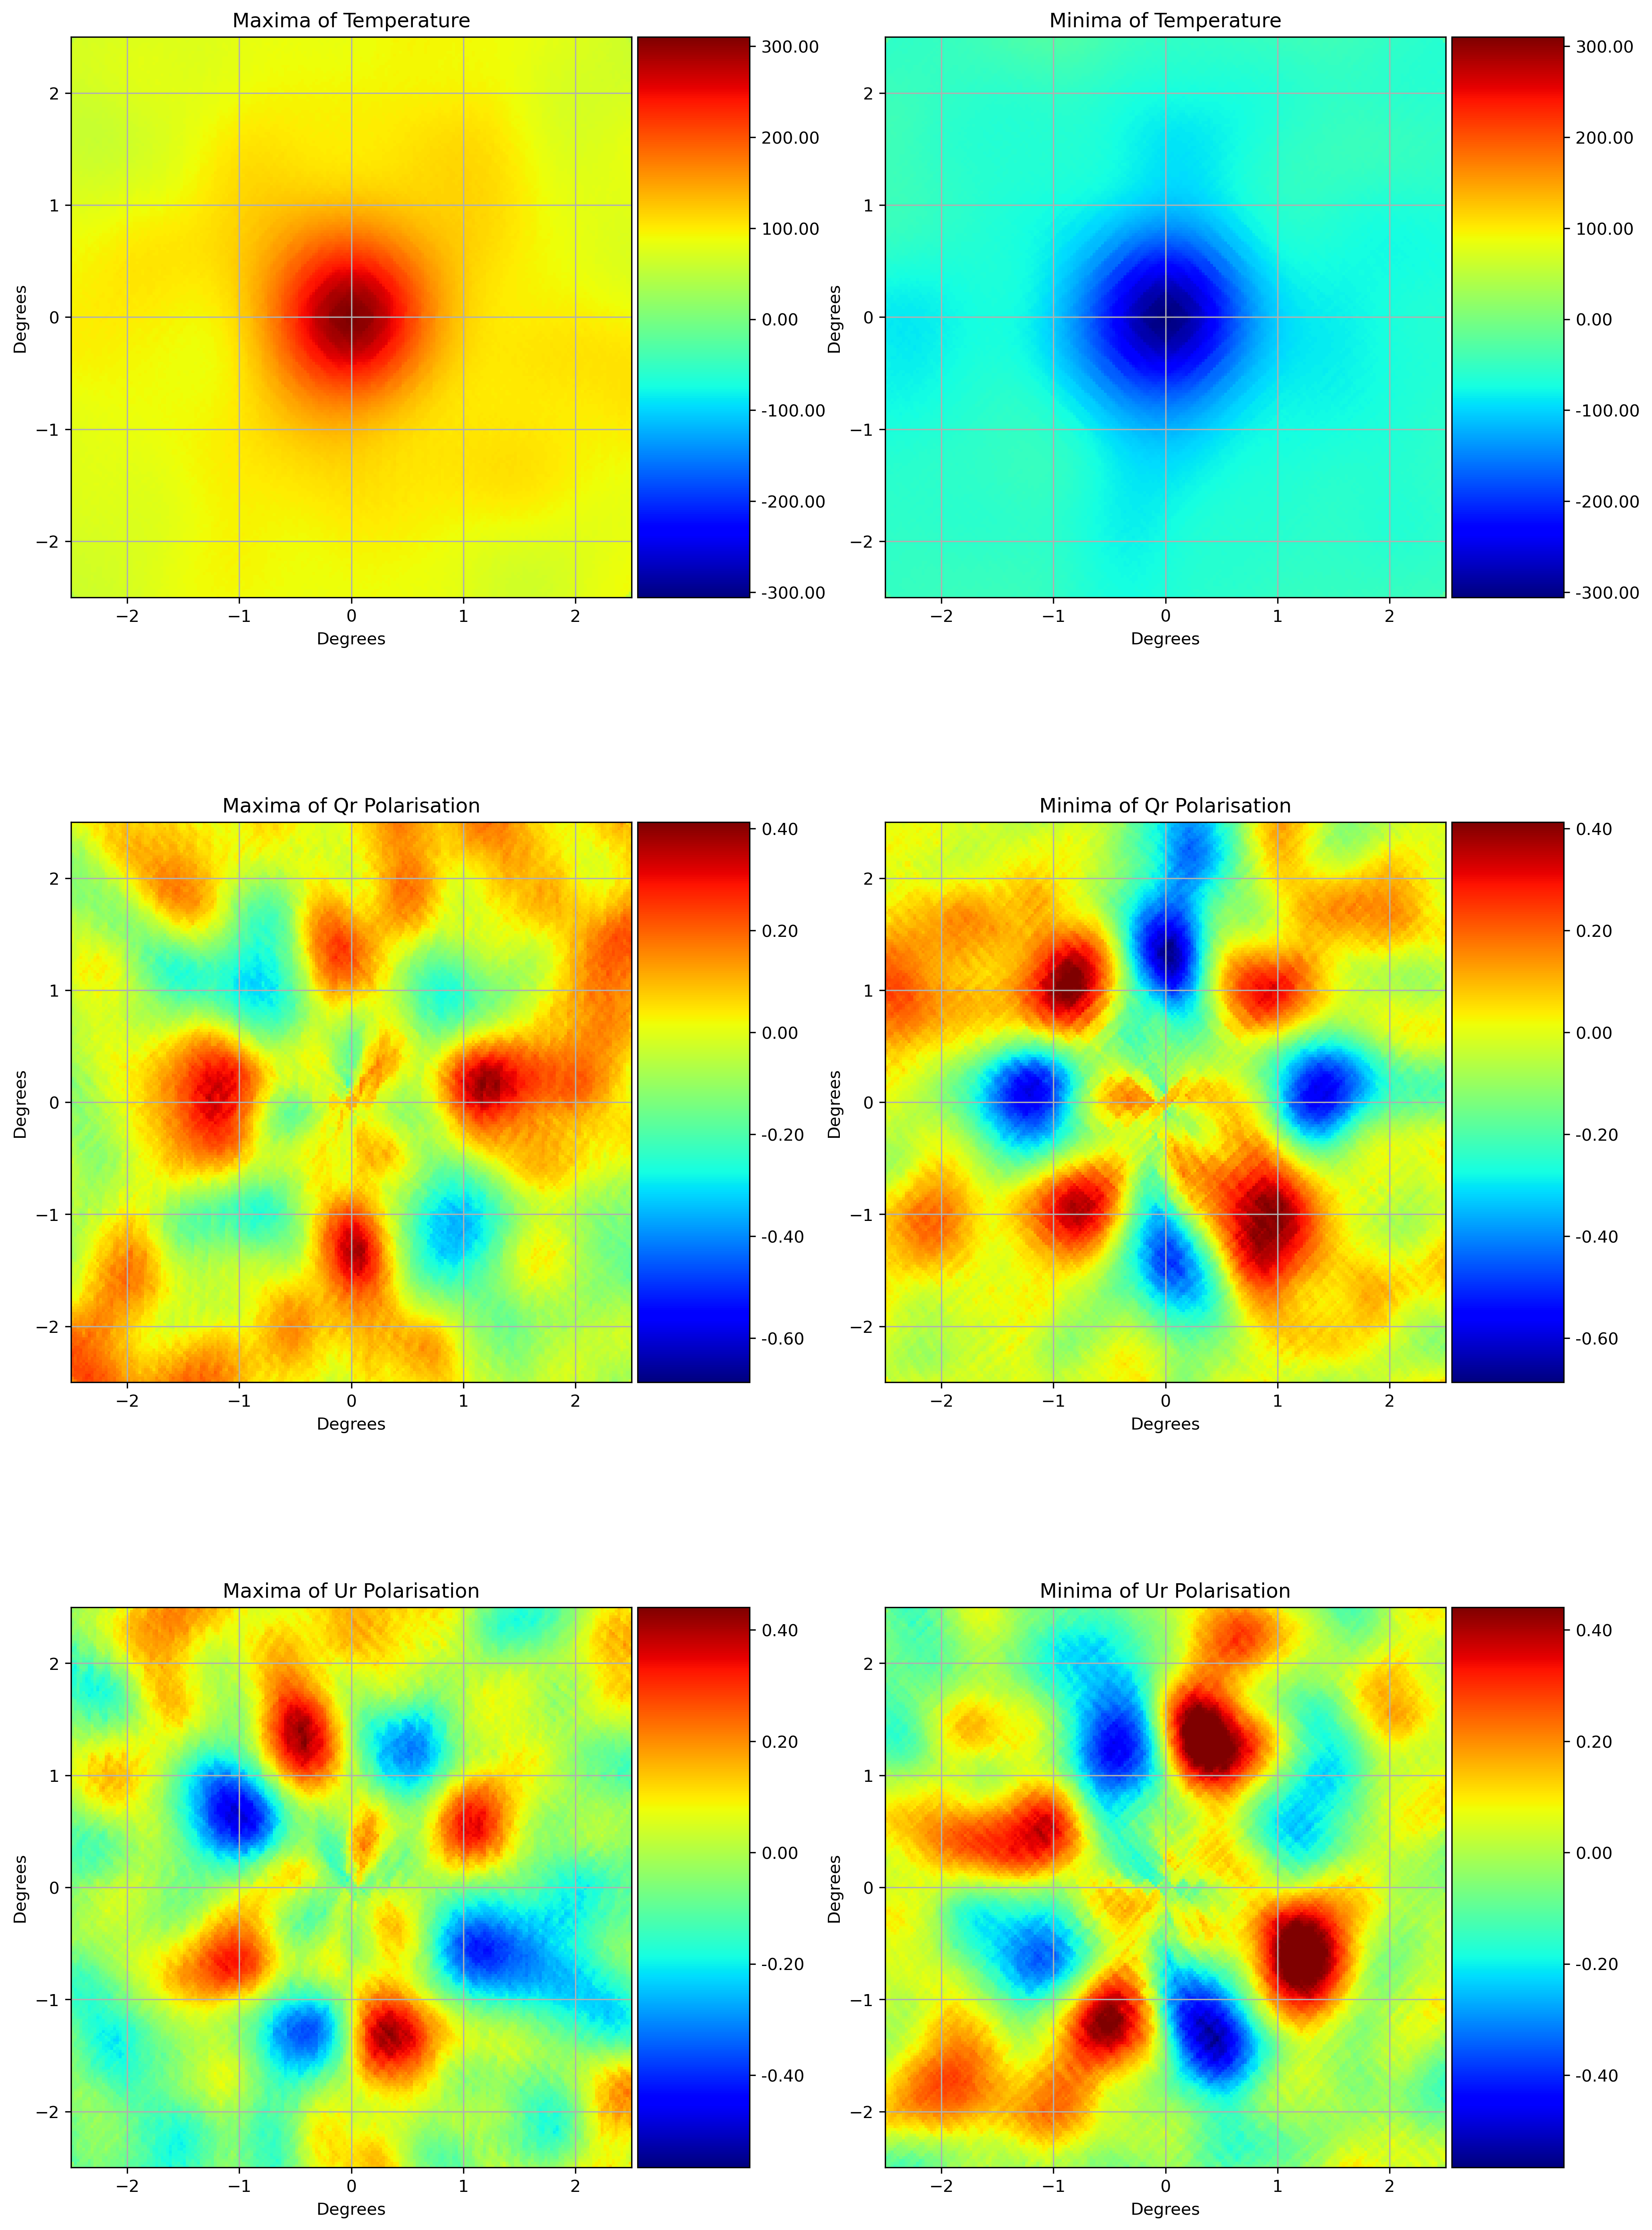

In [35]:
fig, ax = plt.subplots(3, 2, figsize=(16, 24), dpi=300)
for pindx, ll in zip(range(3), ["Temperature", "Qr Polarisation", "Ur Polarisation"]):
    im_hot = ax[pindx, 0].imshow(
        max_stacked[pindx, :, :],
        extent=(-2.5, 2.5, -2.5, 2.5),
        cmap="jet",
        vmin=np.min(min_stacked[pindx, :, :]),
        vmax=np.max(max_stacked[pindx, :, :]),
    )
    ax[pindx, 0].grid()
    ax[pindx, 0].set_xlabel("Degrees")
    ax[pindx, 0].set_ylabel("Degrees")
    ax[pindx, 0].set_title(r"Maxima of %s" % ll)
    divider_hot = make_axes_locatable(ax[pindx, 0])
    cax_hot = divider_hot.append_axes("right", size="20%", pad=0.05)
    cbar_hot = plt.colorbar(im_hot, cax=cax_hot, format="%.2f")

    im_cold = ax[pindx, 1].imshow(
        min_stacked[pindx, :, :],
        extent=(-2.5, 2.5, -2.5, 2.5),
        cmap="jet",
        vmin=np.min(min_stacked[pindx, :, :]),
        vmax=np.max(max_stacked[pindx, :, :]),
    )
    ax[pindx, 1].grid()
    ax[pindx, 1].set_xlabel("Degrees")
    ax[pindx, 1].set_ylabel("Degrees")
    ax[pindx, 1].set_title(r"Minima of %s" % ll)
    divider_cold = make_axes_locatable(ax[pindx, 1])
    cax_cold = divider_cold.append_axes("right", size="20%", pad=0.05)
    cbar_cold = plt.colorbar(im_cold, cax=cax_cold, format="%.2f")

fig.show()

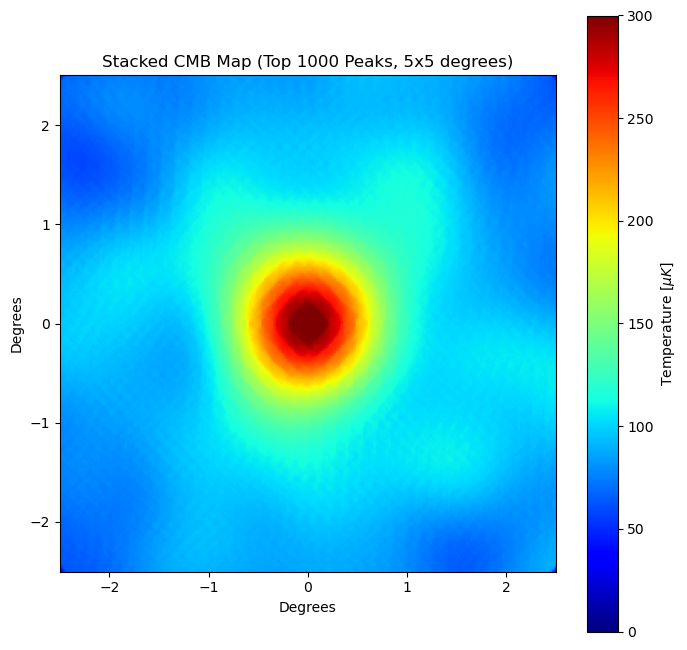

In [39]:
plt.figure(figsize=(8, 8))
plt.imshow(
    max_stacked[0, :, :], extent=(-2.5, 2.5, -2.5, 2.5), cmap="jet", vmin=0, vmax=300
)
plt.colorbar(label="Temperature [$\mu K$]")
plt.title(r"Stacked CMB Map (Top %.d Peaks, 5x5 degrees)" % no_spots)
plt.xlabel("Degrees")
plt.ylabel("Degrees")
plt.show()

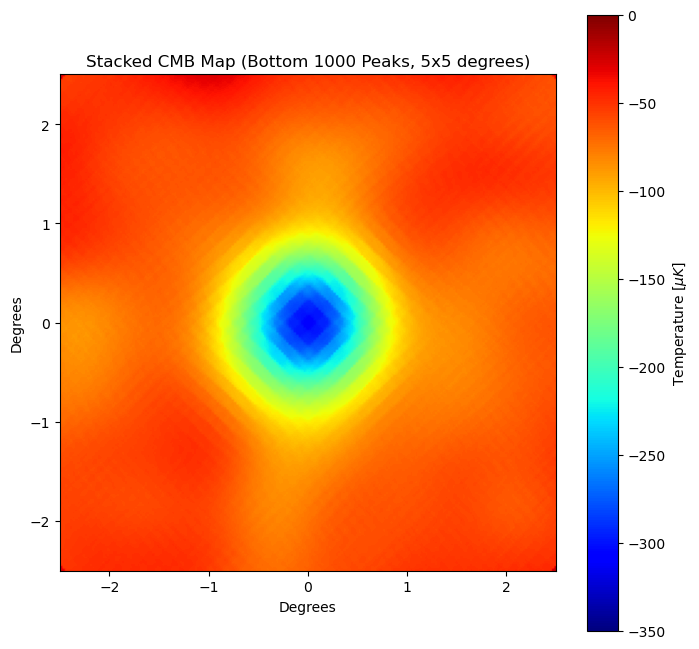

In [42]:
plt.figure(figsize=(8, 8))
plt.imshow(
    min_stacked[0, :, :],
    extent=(-2.5, 2.5, -2.5, 2.5),
    cmap="jet",
    vmin=-350,
    vmax=0,
)
plt.colorbar(label="Temperature [$\mu K$]")
plt.title(r"Stacked CMB Map (Bottom %.d Peaks, 5x5 degrees)" % no_spots)
plt.xlabel("Degrees")
plt.ylabel("Degrees")
plt.show()